This will adapt structure window size

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [4]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [5]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [6]:
def create_seq_prot_t5_model(seq_length=33):
    """Create model with sequence and ProtT5 tracks"""

    regularizer = tf.keras.regularizers.l2(0.01)

    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', 
                                 kernel_regularizer=regularizer, 
                                 name='seq_features')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)

    # ProtT5 track
    prot_t5_input = tf.keras.layers.Input(shape=(1024,), name='prot_t5_input')
    x_prot_t5 = tf.keras.layers.Dense(256, kernel_regularizer=regularizer)(prot_t5_input)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dense(128, activation='relu',
                                     kernel_regularizer=regularizer)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)

    # Create learnable weights layer for two tracks
    weight_layer = tf.keras.layers.Dense(2, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_prot_t5]))

    # Apply weights
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_prot_t5 = tf.keras.layers.Multiply(name='weighted_prot_t5')([
        x_prot_t5,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])

    # Combine features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_prot_t5])

    # Final layers with more regularization
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=regularizer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32, activation='relu', 
                            kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, prot_t5_input], outputs=outputs)

    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'prot_t5': float(normalized[1])
            }
        return {'sequence': 0.5, 'prot_t5': 0.5}

    model.get_track_weights = get_track_weights
    return model

In [7]:
def train_and_evaluate():
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_features_train_latest.csv")
    test_df = pd.read_csv("../data/processed_features_test_latest.csv")
    
    # Load ProtT5 embeddings
    print("Loading ProtT5 embeddings...")
    train_pos_dict, train_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_negative_ProtT5-XL-UniRef50.csv'
    )
    test_pos_dict, test_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_negative_ProtT5-XL-UniRef50.csv'
    )
    
    # Align data
    print("Aligning data...")
    X_train_prot_t5, train_df_aligned = prepare_aligned_data(train_df, train_pos_dict, train_neg_dict)
    X_test_prot_t5, test_df_aligned = prepare_aligned_data(test_df, test_pos_dict, test_neg_dict)
    
    # Prepare sequence data
    X_train_seq = prepare_sequence_data(train_df_aligned)
    X_test_seq = prepare_sequence_data(test_df_aligned)
    
    y_train = train_df_aligned['label'].values
    y_test = test_df_aligned['label'].values
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df_aligned['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df_aligned['label'].value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_prot_t5: {X_train_prot_t5.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_prot_t5: {X_test_prot_t5.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_seq_prot_t5_model(seq_length=33)
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_prot_t5[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_prot_t5[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_prot_t5[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_prot_t5])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"ProtT5 weight: {final_weights['prot_t5']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_prot_t5_weight = np.mean([w['prot_t5'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_prot_t5_weight = np.std([w['prot_t5'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"ProtT5 weight: {avg_prot_t5_weight:.4f} ± {std_prot_t5_weight:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution:
label
1    4592
0    4261
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8853, 33)
X_train_prot_t5: (8853, 1024)
X_test_seq: (2737, 33)
X_test_prot_t5: (2737, 1024)
y_train: (8853,)
y_test: (2737,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-15 01:37:46.364812: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-15 01:37:46.364843: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-15 01:37:46.364849: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-15 01:37:46.364868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 01:37:46.364879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-15 01:37:47.504628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.5091 - loss: 8.0245 - val_accuracy: 0.5104 - val_loss: 5.7815 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5432 - loss: 5.2821 - val_accuracy: 0.5652 - val_loss: 3.6889 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5882 - loss: 3.3504 - val_accuracy: 0.6669 - val_loss: 2.3472 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6526 - loss: 2.1645 - val_accuracy: 0.6945 - val_loss: 1.6156 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6781 - loss: 1.5256 - val_accuracy: 0.6900 - val_loss: 1.2329 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7112 - loss: 1.1838 - val_accuracy: 0.7002 - val_loss: 1.0629 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7186 - loss: 1.0267

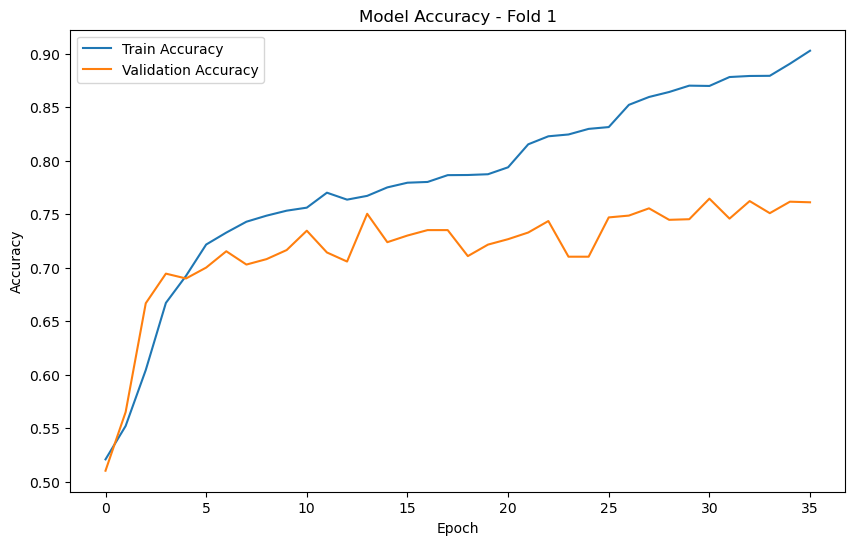

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7645
Balanced Accuracy: 0.7646
MCC: 0.5405
Sensitivity: 0.8667
Specificity: 0.6625

Learned track weights for fold 1:
Sequence weight: 0.6415
ProtT5 weight: 0.3585

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.5045 - loss: 8.1830 - val_accuracy: 0.6471 - val_loss: 5.9337 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5590 - loss: 5.4748 - val_accuracy: 0.6669 - val_loss: 3.8471 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6065 - loss: 3.5151 - val_accuracy: 0.6821 - val_loss: 2.5024 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6564 - loss: 2.3063 - val_accuracy: 0.6928 - val_loss: 1.7338 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6845 - loss: 1.6074 - val_accuracy: 0.6900 - val_loss: 1.3061 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6911 - loss: 1.2404 - val_accuracy: 0.7165 - val_loss: 1.0612 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7101 - loss: 1.0368

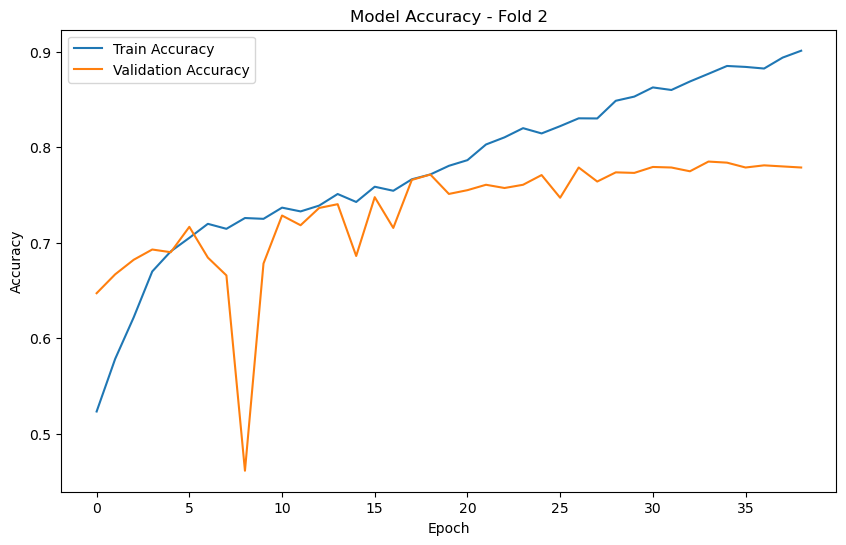

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7849
Balanced Accuracy: 0.7771
MCC: 0.5641
Sensitivity: 0.8552
Specificity: 0.6989

Learned track weights for fold 2:
Sequence weight: 0.6514
ProtT5 weight: 0.3486

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.5167 - loss: 8.1366 - val_accuracy: 0.5759 - val_loss: 5.9953 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5414 - loss: 5.5350 - val_accuracy: 0.5923 - val_loss: 3.9085 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5802 - loss: 3.5816 - val_accuracy: 0.6398 - val_loss: 2.5395 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6247 - loss: 2.3268 - val_accuracy: 0.6872 - val_loss: 1.7318 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6653 - loss: 1.6230 - val_accuracy: 0.7047 - val_loss: 1.3033 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6845 - loss: 1.2412 - val_accuracy: 0.6985 - val_loss: 1.0687 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7048 - loss: 1.0500

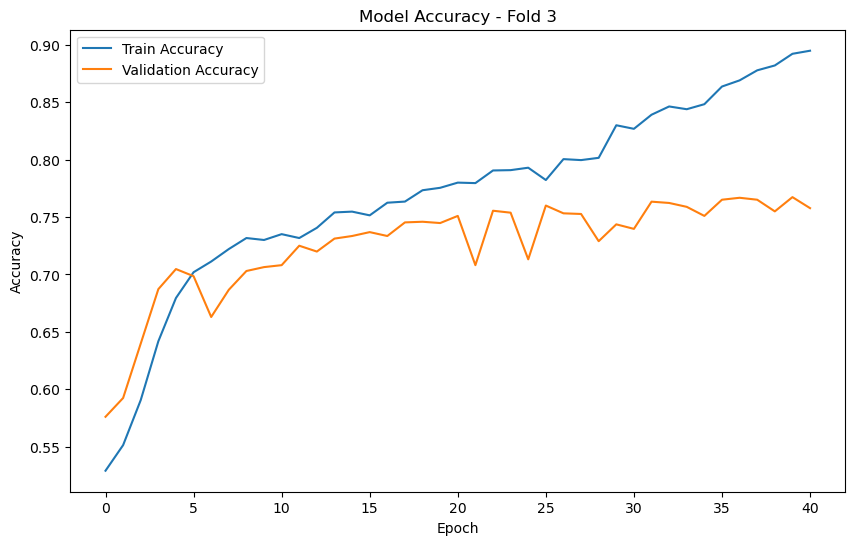

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7651
Balanced Accuracy: 0.7644
MCC: 0.5301
Sensitivity: 0.7945
Specificity: 0.7344

Learned track weights for fold 3:
Sequence weight: 0.6507
ProtT5 weight: 0.3493

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.5145 - loss: 8.0493 - val_accuracy: 0.5718 - val_loss: 5.6839 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5536 - loss: 5.1656 - val_accuracy: 0.6164 - val_loss: 3.5371 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5781 - loss: 3.2299 - val_accuracy: 0.6802 - val_loss: 2.2469 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6484 - loss: 2.0933 - val_accuracy: 0.7198 - val_loss: 1.5420 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.6909 - loss: 1.4608 - val_accuracy: 0.7130 - val_loss: 1.1945 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7174 - loss: 1.1599 - val_accuracy: 0.7350 - val_loss: 1.0081 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7133 - loss: 0.9991

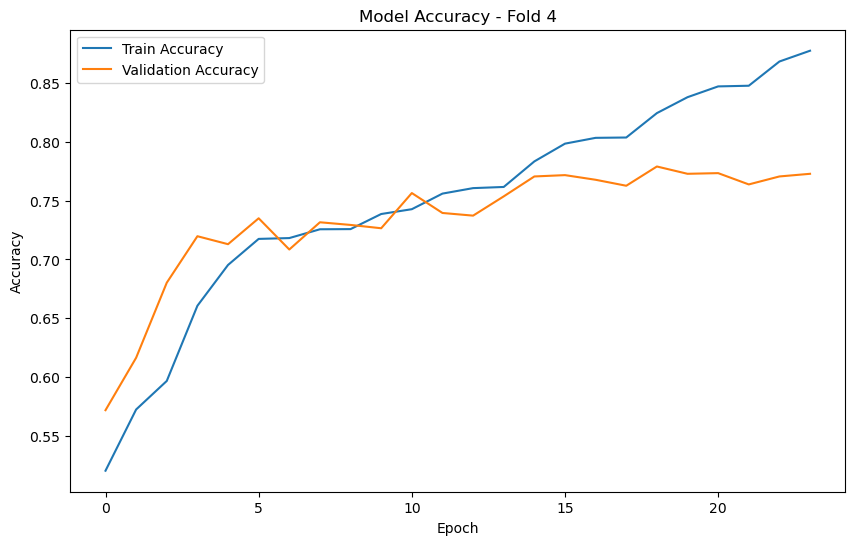

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Results:
Accuracy: 0.7791
Balanced Accuracy: 0.7772
MCC: 0.5600
Sensitivity: 0.8408
Specificity: 0.7136

Learned track weights for fold 4:
Sequence weight: 0.5786
ProtT5 weight: 0.4214

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.4919 - loss: 7.9895 - val_accuracy: 0.5684 - val_loss: 5.5439 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5489 - loss: 4.9951 - val_accuracy: 0.6401 - val_loss: 3.3414 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6154 - loss: 2.9957 - val_accuracy: 0.6785 - val_loss: 2.0983 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6625 - loss: 1.9406 - val_accuracy: 0.7000 - val_loss: 1.4379 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6883 - loss: 1.3712 - val_accuracy: 0.6977 - val_loss: 1.1254 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6991 - loss: 1.0874 - val_accuracy: 0.6938 - val_loss: 0.9721 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7053 - loss: 0.9509

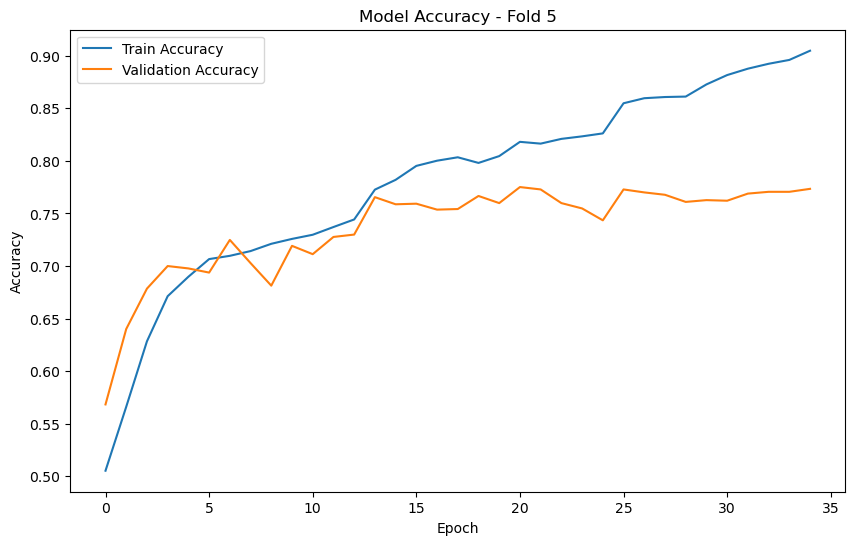

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7627
Balanced Accuracy: 0.7633
MCC: 0.5264
Sensitivity: 0.7459
Specificity: 0.7808

Learned track weights for fold 5:
Sequence weight: 0.5703
ProtT5 weight: 0.4297

Average track weights across folds:
Sequence weight: 0.6185 ± 0.0362
ProtT5 weight: 0.3815 ± 0.0362

Average Cross-validation Results:
ACC: 0.7713 ± 0.0090
BALANCED_ACC: 0.7693 ± 0.0064
MCC: 0.5442 ± 0.0153
SN: 0.8206 ± 0.0447
SP: 0.7180 ± 0.0392

Final Test Set Results:
Accuracy: 0.7326
Balanced Accuracy: 0.7819
MCC: 0.3398
Sensitivity: 0.8417
Specificity: 0.7221
Confusion Matrix:
[[1803  694]
 [  38  202]]


In [8]:
if __name__ == "__main__":
    model = train_and_evaluate()